# Labeling and MetaLabeling

## Overview

In this chapter of the book AFML, De Prado introduces several novel techniques for labeling returns for the purposes of supervised machine learning.

First he identifies the typical issues of fixed-time horizon labeling methods - primarily that it is easy to mislabel a return due to dynamic nature of volatility throughout a trading period.

More importantly he addresses a major overlooked aspect of the financial literature. He emphasizes that every investment strategy makes use of stop-loss limits of some kind, whether those are enforced by a margin call, risk department or self-imposed. He highlights how unrealistic it is to test/implement/propagate a strategy that profits from positions that would have been stopped out.

> That virtually no publication accounts for that when labeling observations tells you something about the current state of financial literature.
> -De Prado, "Advances in Financial Machine Learning", pg.44

He also introduces a technique called metalabeling, which is used to augment a strategy by improving recall while also reducing the likelihood of overfitting.


In [1]:
%matplotlib widget
%reload_ext watermark
%watermark

%reload_ext autoreload
%autoreload 2

# import standard libs
from multiprocessing import cpu_count
import inspect
import pandas as pd
from tqdm import tqdm

import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-talk')
plt.style.use('bmh')
plt.rcParams['font.size'] = 9.5
plt.rcParams['font.weight'] = 'medium'
plt.rcParams['figure.figsize'] = 10,7
blue, green, red, purple, gold, teal = sns.color_palette('colorblind', 6)

# import util libs
import bars as brs
import chap3_funcs as fns

RANDOM_STATE = 777

print()
%watermark -p pandas,numpy,sklearn,statsmodels,scipy,matplotlib,seaborn

Last updated: 2024-03-24T15:23:44.621168+07:00

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 8.12.3

Compiler    : GCC 9.4.0
OS          : Linux
Release     : 5.15.0-56-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 12
Architecture: 64bit



/tmp/ipykernel_269904/4179126.py:23: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-talk')



pandas     : 2.0.3
numpy      : 1.24.4
sklearn    : 0.0
statsmodels: 0.14.1
scipy      : 1.10.1
matplotlib : 3.7.5
seaborn    : 0.13.2



## Code Snippets

### Daily Volatility Estimator [3.1]

In [2]:
print(inspect.getsource(fns.getDailyVol))

def getDailyVol(close, span0=100):
    df0 = close.index.searchsorted(close.index - pd.Timedelta(days=1))
    df0 = df0[df0 > 0]
    df0 = (pd.Series(close.index[df0 - 1],
                     index=close.index[close.shape[0] - df0.shape[0]:]))
    try:
        df0 = close.loc[df0.index] / close.loc[df0.values].values - 1  # daily rets
    except Exception as e:
        print(f'error: {e}\nplease confirm no duplicate indices')
    df0 = df0.ewm(span=span0).std().rename('dailyVol')
    return df0



### Labeling for side and size [3.5]

In [3]:
print(inspect.getsource(fns.getBinsOld))

def getBinsOld(events, close):
    # 1) prices aligned with events
    events_ = events.dropna(subset=['t1'])
    px = events_.index.union(events_['t1'].values).drop_duplicates()
    px = close.reindex(px, method='bfill')

    # 2) create out object
    out = pd.DataFrame(index=events_.index)
    out['ret'] = px.loc[events_['t1'].values].values / px.loc[events_.index] - 1
    out['bin'] = np.sign(out['ret'])
    # where out index and t1 (vertical barrier) intersect label 0
    try:
        locs = out.query('index in @t1').index
        out.loc[locs, 'bin'] = 0
    except:
        pass
    return out



### Dropping Unnecessary Labels [3.8]

In [4]:
print(inspect.getsource(fns.dropLabels))

def dropLabels(events, minPct=.05):
    # apply weights, drop labels with insufficient examples
    while True:
        df0 = events['bin'].value_counts(normalize=True)
        if df0.min() > minPct or df0.shape[0] < 3: break
        print('dropped label: ', df0.argmin(), df0.min())
        events = events[events['bin'] != df0.argmin()]
    return events



### Linear Partitions [20.4.1]

In [5]:
print(inspect.getsource(fns.linParts))

def linParts(numAtoms, numThreads):
    # partition of atoms with a single loop
    parts = np.linspace(0, numAtoms, min(numThreads, numAtoms) + 1)
    parts = np.ceil(parts).astype(int)
    return parts



In [6]:
print(inspect.getsource(fns.nestedParts))

def nestedParts(numAtoms, numThreads, upperTriang=False):
    # partition of atoms with an inner loop
    parts, numThreads_ = [0], min(numThreads, numAtoms)
    for num in range(numThreads_):
        part = 1 + 4 * (parts[-1] ** 2 + parts[-1] + numAtoms * (numAtoms + 1.) / numThreads_)
        part = (-1 + part ** .5) / 2.
        parts.append(part)
    parts = np.round(parts).astype(int)
    if upperTriang:  # the first rows are heaviest
        parts = np.cumsum(np.diff(parts)[::-1])
        parts = np.append(np.array([0]), parts)
    return parts



### single-thread execution for debugging [20.8]

In [7]:
print(inspect.getsource(fns.processJobs_))

def processJobs_(jobs):
    # Run jobs sequentially, for debugging
    out = []
    for job in jobs:
        out_ = expandCall(job)
        out.append(out_)
    return out



### Example of async call to multiprocessing lib [20.9]

In [8]:
print(inspect.getsource(fns.reportProgress))
print(inspect.getsource(fns.processJobs))

def reportProgress(jobNum, numJobs, time0, task):
    # Report progress as asynch jobs are completed
    msg = [float(jobNum) / numJobs, (time.time() - time0) / 60.]
    msg.append(msg[1] * (1 / msg[0] - 1))
    timeStamp = str(dt.datetime.fromtimestamp(time.time()))
    msg = timeStamp + ' ' + str(round(msg[0] * 100, 2)) + '% ' + task + ' done after ' + \
          str(round(msg[1], 2)) + ' minutes. Remaining ' + str(round(msg[2], 2)) + ' minutes.'
    if jobNum < numJobs:
        sys.stderr.write(msg + '\r')
    else:
        sys.stderr.write(msg + '\n')
    return

def processJobs(jobs, task=None, numThreads=24):
    # Run in parallel.
    # jobs must contain a 'func' callback, for expandCall
    if task is None: task = jobs[0]['func'].__name__
    pool = mp.Pool(processes=numThreads)
    outputs, out, time0 = pool.imap_unordered(expandCall, jobs), [], time.time()
    # Process asyn output, report progress
    for i, out_ in enumerate(outputs, 1):
        out.append(out_)
        re

### Unwrapping the Callback [20.10]

In [9]:
print(inspect.getsource(fns.expandCall))

def expandCall(kargs):
    # Expand the arguments of a callback function, kargs['func']
    func = kargs['func']
    del kargs['func']
    out = func(**kargs)
    return out



## Exercises
### Import Dataset

Note this dataset below has been resampled to 1s and then NaNs removed. This was done to remove any duplicate indices not accounted for in a simple call to pd.DataFrame.drop_duplicates().

In [10]:
df = pd.read_parquet('./data/processed/IVE_dollarValue_resampled_1s.parquet')
print(df.head())
print(df.describe())

                     price    bid    ask   size      v        dv
2009-09-28 09:30:00  50.75  50.70  50.79  369.0  369.0  18715.99
2009-09-28 09:31:32  50.75  50.75  50.76  100.0  100.0   5075.00
2009-09-28 09:31:33  50.75  50.72  50.75  100.0  100.0   5075.00
2009-09-28 09:31:50  50.75  50.73  50.76  300.0  300.0  15225.00
2009-09-28 09:31:51  50.75  50.74  50.76  300.0  300.0  15225.00
               price            bid            ask          size  \
count  941297.000000  941297.000000  941297.000000  9.412970e+05   
mean       80.973359      80.962656      80.981079  5.171226e+02   
std        18.864476      18.867945      18.864951  5.504577e+03   
min        29.600000       0.000000       0.000000  0.000000e+00   
25%        62.680000      62.670000      62.690000  1.410000e+02   
50%        84.499950      84.490000      84.510000  2.250000e+02   
75%        94.033000      94.020000      94.040000  4.481000e+02   
max       121.120000     121.120000     121.700000  1.857142e+06  

### [3.1] Form Dollar Bars

In [11]:
dbars = brs.dollar_bar_df(df, 'dv', 1_000_000).drop_duplicates().dropna()
print(dbars.head())
print(dbars.describe())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 941297/941297 [00:00<00:00, 4249361.23it/s]

                         price    bid    ask    size       v          dv
2009-09-28 09:53:49  51.138000  51.13  51.14   970.2   970.2  49615.0280
2009-09-28 10:06:04  51.190000  51.19  51.20   100.0   100.0   5119.0000
2009-09-28 10:19:50  51.210000  51.21  51.22   100.0   100.0   5121.0000
2009-09-28 10:32:01  51.379725  51.36  51.38   575.0   575.0  29543.2725
2009-09-28 10:53:46  51.330000  51.32  51.33  1500.0  1500.0  76995.0000
              price           bid           ask          size             v  \
count  30860.000000  30860.000000  30860.000000  3.086000e+04  3.086000e+04   
mean      84.791975     84.774141     84.793878  4.336482e+03  4.336482e+03   
std       18.337710     18.348887     18.348416  3.002203e+04  3.002203e+04   
min       42.510000      0.000000      0.000000  1.000000e+02  1.000000e+02   
25%       66.929975     66.920000     66.930000  3.150000e+02  3.150000e+02   
50%       88.789950     88.780000     88.790000  7.300000e+02  7.300000e+02   
75%      

#### (a) Run cusum filter with threshold equal to std dev of daily returns

In [12]:
close = dbars.price.copy()
dailyVol = fns.getDailyVol(close)

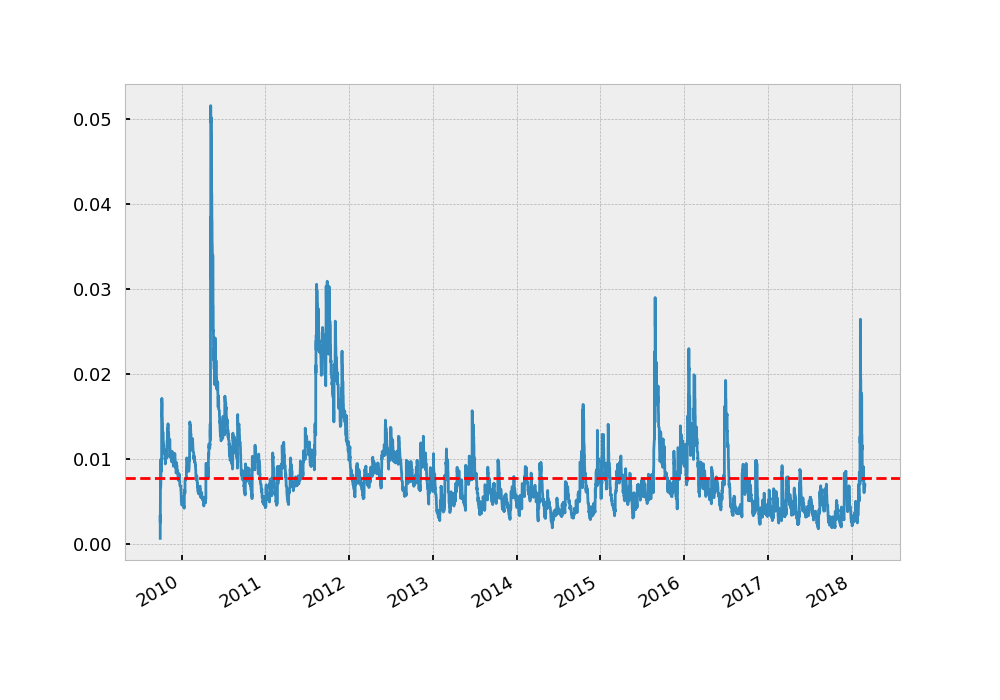

In [13]:
f,ax=plt.subplots()
dailyVol.plot(ax=ax)
ax.axhline(dailyVol.mean(),ls='--',color='r')

##### Symmetric CUSUM Filter [2.5.2.1]
The purpose of running CUMSUM filter is to find where continuous days that cummulative of volatility rate of dates larger (or smaller) than some positive (or negative) threshold.

In [14]:
print(inspect.getsource(fns.getTEvents))

def getTEvents(gRaw, h):
    tEvents, sPos, sNeg = [], 0, 0
    diff = np.log(gRaw).diff().dropna()
    for i in tqdm(diff.index[1:]):
        try:
            pos, neg = float(sPos + diff.loc[i]), float(sNeg + diff.loc[i])
        except Exception as e:
            print(e)
            print(sPos + diff.loc[i], type(sPos + diff.loc[i]))
            print(sNeg + diff.loc[i], type(sNeg + diff.loc[i]))
            break
        sPos, sNeg = max(0., pos), min(0., neg)
        if sNeg < -h:
            sNeg = 0
            tEvents.append(i)
        elif sPos > h:
            sPos = 0
            tEvents.append(i)
    return pd.DatetimeIndex(tEvents)



In [15]:
# Something is wrong, the `tEvents` is where the volatility pass the threshold, not the point before
tEvents = fns.getTEvents(close,h=dailyVol.mean())
tEvents = tEvents[1:]
tEvents

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30858/30858 [00:00<00:00, 51575.87it/s]


DatetimeIndex(['2009-09-30 09:45:21', '2009-09-30 13:31:12',
               '2009-10-01 09:43:58', '2009-10-01 11:12:07',
               '2009-10-02 09:44:14', '2009-10-02 10:35:05',
               '2009-10-05 09:51:42', '2009-10-05 14:55:48',
               '2009-10-06 09:29:52', '2009-10-06 11:32:02',
               ...
               '2018-02-16 14:23:51', '2018-02-20 09:30:00',
               '2018-02-20 15:21:07', '2018-02-21 14:04:12',
               '2018-02-21 15:12:30', '2018-02-22 12:18:21',
               '2018-02-22 14:56:14', '2018-02-23 11:37:32',
               '2018-02-23 15:58:39', '2018-02-26 13:06:34'],
              dtype='datetime64[ns]', length=2277, freq=None)

#### (b) Adding Vertical Barrier [3.4]

In [16]:
print(inspect.getsource(fns.addVerticalBarrier))

def addVerticalBarrier(tEvents, close, numDays=1):
    t1 = close.index.searchsorted(tEvents + pd.Timedelta(days=numDays))
    t1 = t1[t1 < close.shape[0]]
    t1 = (pd.Series(close.index[t1], index=tEvents[:t1.shape[0]]))
    return t1



In [17]:
t1 = fns.addVerticalBarrier(tEvents, close, numDays=1)
t1

2009-09-30 09:45:21   2009-10-01 10:00:48
2009-09-30 13:31:12   2009-10-01 13:33:25
2009-10-01 09:43:58   2009-10-02 09:44:14
2009-10-01 11:12:07   2009-10-02 11:50:21
2009-10-02 09:44:14   2009-10-05 09:51:42
                              ...        
2018-02-21 15:12:30   2018-02-22 15:16:50
2018-02-22 12:18:21   2018-02-23 12:30:16
2018-02-22 14:56:14   2018-02-23 15:02:21
2018-02-23 11:37:32   2018-02-26 09:30:00
2018-02-23 15:58:39   2018-02-26 09:30:00
Length: 2276, dtype: datetime64[ms]

#### (c) Apply triple-barrier method where ptSl = [1,1] and t1 is the series created in 1.b
##### Multiprocessing snippet [20.7]

In [18]:
print(inspect.getsource(fns.mpPandasObj))

def mpPandasObj(func, pdObj, numThreads=24, mpBatches=1, linMols=True, **kargs):
    '''
    Parallelize jobs, return a dataframe or series
    + func: function to be parallelized. Returns a DataFrame
    + pdObj[0]: Name of argument used to pass the molecule
    + pdObj[1]: List of atoms that will be grouped into molecules
    + kwds: any other argument needed by func

    Example: df1=mpPandasObj(func,('molecule',df0.index),24,**kwds)
    '''

    # if linMols:parts=linParts(len(argList[1]),numThreads*mpBatches)
    # else:parts=nestedParts(len(argList[1]),numThreads*mpBatches)
    if linMols:
        parts = linParts(len(pdObj[1]), numThreads * mpBatches)
    else:
        parts = nestedParts(len(pdObj[1]), numThreads * mpBatches)

    jobs = []
    for i in range(1, len(parts)):
        job = {pdObj[0]: pdObj[1][parts[i - 1]: parts[i]], 'func': func}
        job.update(kargs)
        jobs.append(job)
    if numThreads == 1:
        out = processJobs_(jobs)
    else:
        out = p

##### Function to get time of First Touch (getEvents) [3.3], [3.6]

In [19]:
print(inspect.getsource(fns.getEvents))

def getEvents(close, tEvents, ptSl, trgt, minRet, numThreads, t1=False, side=None):
    # 1) get target
    trgt = trgt.loc[tEvents]
    trgt = trgt[trgt > minRet]  # minRet

    # 2) get t1 (max holding period)
    if t1 is False:
        t1 = pd.Series(pd.NaT, index=tEvents)

    # 3) form events object, apply stop loss on t1
    if side is None:
        side_, ptSl_ = pd.Series(1., index=trgt.index), [ptSl[0], ptSl[0]]
    else:
        intersect_index = side.index.intersection(trgt.index)
        side_, ptSl_ = side.loc[intersect_index], ptSl[:2]

    events = (pd.concat({'t1': t1, 'trgt': trgt, 'side': side_}, axis=1)
              .dropna(subset=['trgt']))
    df0 = mpPandasObj(func=applyPtSlOnT1, pdObj=('molecule', events.index),
                      numThreads=numThreads, close=close, events=events,
                      ptSl=ptSl_)
    events['t1'] = df0.dropna(how='all').min(axis=1)  # pd.min ignores nan
    if side is None:
        events = events.drop('side', axis=1)
    r

##### Triple-Barrier Labeling Method [3.2]

In [20]:
print(inspect.getsource(fns.applyPtSlOnT1))

def applyPtSlOnT1(close, events, ptSl, molecule):
    # apply stop loss/profit taking, if it takes place before t1 (end of event)

    events_ = events.loc[molecule]
    out = events_[['t1']].copy(deep=True)
    if ptSl[0] > 0:
        pt = ptSl[0] * events_['trgt']
    else:
        pt = pd.Series(index=events.index)  # NaNs
    if ptSl[1] > 0:
        sl = -ptSl[1] * events_['trgt']
    else:
        sl = pd.Series(index=events.index)  # NaNs
    for loc, t1 in events_['t1'].fillna(close.index[-1]).items():
        df0 = close[loc:t1]  # path prices
        df0 = (df0 / close[loc] - 1) * events_.at[loc, 'side']  # path returns
        out.loc[loc, 'sl'] = df0[df0 < sl[loc]].index.min()  # earliest stop loss
        out.loc[loc, 'pt'] = df0[df0 > pt[loc]].index.min()  # earliest profit taking
    return out



In [21]:
# create target series
ptsl = [1,1]
target=dailyVol
# select minRet
minRet = 0.01

# Run in single-threaded mode on Windows
import platform
if platform.system() == "Windows":
    cpus = 1
else:
    cpus = cpu_count() - 1
print(f'cpus = {cpus}')
    
events = fns.getEvents(close,tEvents,ptsl,target,minRet,cpus,t1=t1)
print(events)

cpus = 11
                                     t1      trgt
2009-10-05 14:55:48 2009-10-06 11:32:02  0.013612
2009-10-06 09:29:52 2009-10-07 09:47:16  0.015728
2009-10-06 11:32:02 2009-10-07 11:48:22  0.016744
2009-10-06 14:07:37 2009-10-07 14:22:36  0.016971
2009-10-08 09:29:51 2009-10-09 09:31:12  0.014877
...                                 ...       ...
2018-02-13 13:43:37 2018-02-14 13:53:59  0.014365
2018-02-14 10:30:48 2018-02-15 09:31:56  0.012136
2018-02-14 13:36:02 2018-02-15 13:42:09  0.011688
2018-02-15 09:31:56 2018-02-16 09:42:36  0.011244
2018-02-15 14:05:41 2018-02-16 12:05:18  0.010183

[929 rows x 2 columns]


2024-03-24 15:23:51.188112 100.0% applyPtSlOnT1 done after 0.0 minutes. Remaining 0.0 minutes..


#### (d) Apply getBins to generate labels

##### Expanding getBins to Incorporate Meta-Labeling [3.7]

In [22]:
print(inspect.getsource(fns.getBins))

def getBins(events, close):
    """
    Compute event's outcome (including side information, if provided).
    events is a DataFrame where:
    -events.index is event's starttime
    -events['t1'] is event's endtime
    -events['trgt'] is event's target
    -events['side'] (optional) implies the algo's position side
    Case 1: ('side' not in events): bin in (-1,1) <-label by price action
    Case 2: ('side' in events): bin in (0,1) <-label by pnl (meta-labeling)
    """
    # 1) prices aligned with events
    events_ = events.dropna(subset=['t1'])
    px = events_.index.union(events_['t1'].values).drop_duplicates()
    px = close.reindex(px, method='bfill')

    # 2) create out object
    out = pd.DataFrame(index=events_.index)
    out['ret'] = px.loc[events_['t1'].values].values / px.loc[events_.index] - 1
    if 'side' in events_:
        out['ret'] *= events_['side']  # meta-labeling
    out['bin'] = np.sign(out['ret'])
    if 'side' in events_:
        out.loc[out['ret'] <= 0, 'bi

In [23]:
labels = fns.getBins(events, close)
print(labels)
print(labels.bin.value_counts())

                          ret  bin
2009-10-05 14:55:48  0.015732  1.0
2009-10-06 09:29:52  0.000982  1.0
2009-10-06 11:32:02 -0.006544 -1.0
2009-10-06 14:07:37  0.002648  1.0
2009-10-08 09:29:51 -0.003092 -1.0
...                       ...  ...
2018-02-13 13:43:37  0.010108  1.0
2018-02-14 10:30:48  0.015045  1.0
2018-02-14 13:36:02  0.005056  1.0
2018-02-15 09:31:56  0.003964  1.0
2018-02-15 14:05:41  0.010431  1.0

[929 rows x 2 columns]
bin
 1.0    523
-1.0    406
Name: count, dtype: int64


### [3.2] Use snippet 3.8 to drop under-populated labels

In [24]:
clean_labels = fns.dropLabels(labels)
print(clean_labels)

                          ret  bin
2009-10-05 14:55:48  0.015732  1.0
2009-10-06 09:29:52  0.000982  1.0
2009-10-06 11:32:02 -0.006544 -1.0
2009-10-06 14:07:37  0.002648  1.0
2009-10-08 09:29:51 -0.003092 -1.0
...                       ...  ...
2018-02-13 13:43:37  0.010108  1.0
2018-02-14 10:30:48  0.015045  1.0
2018-02-14 13:36:02  0.005056  1.0
2018-02-15 09:31:56  0.003964  1.0
2018-02-15 14:05:41  0.010431  1.0

[929 rows x 2 columns]


In [25]:
clean_labels.bin.value_counts()

bin
 1.0    523
-1.0    406
Name: count, dtype: int64

### [3.3] Adjust the getBins function to return a 0 whenever the vertical barrier is the one touched first.

In [26]:
print(inspect.getsource(fns.getBinsNew))

def getBinsNew(events, close, t1=None):
    """
    Compute event's outcome (including side information, if provided).
    events is a DataFrame where:
    -events.index is event's starttime
    -events['t1'] is event's endtime
    -events['trgt'] is event's target
    -events['side'] (optional) implies the algo's position side
    -t1 is original vertical barrier series
    Case 1: ('side' not in events): bin in (-1,1) <-label by price action
    Case 2: ('side' in events): bin in (0,1) <-label by pnl (meta-labeling)
    """

    # 1) prices aligned with events
    events_ = events.dropna(subset=['t1'])
    px = events_.index.union(events_['t1'].values).drop_duplicates()
    px = close.reindex(px, method='bfill')

    # 2) create out object
    out = pd.DataFrame(index=events_.index)
    out['ret'] = px.loc[events_['t1'].values].values / px.loc[events_.index] - 1
    if 'side' in events_:
        out['ret'] *= events_['side']  # meta-labeling
    out['bin'] = np.sign(out['ret'])

    

In [27]:
labels_new = fns.getBinsNew(events, close, t1=t1)
print(labels_new)
print(labels_new.bin.value_counts())

                          ret  bin
2009-10-05 14:55:48  0.015732  1.0
2009-10-06 09:29:52  0.000982  0.0
2009-10-06 11:32:02 -0.006544  0.0
2009-10-06 14:07:37  0.002648  0.0
2009-10-08 09:29:51 -0.003092  0.0
...                       ...  ...
2018-02-13 13:43:37  0.010108  0.0
2018-02-14 10:30:48  0.015045  1.0
2018-02-14 13:36:02  0.005056  0.0
2018-02-15 09:31:56  0.003964  0.0
2018-02-15 14:05:41  0.010431  1.0

[929 rows x 2 columns]
bin
 0.0    673
-1.0    138
 1.0    118
Name: count, dtype: int64


### [3.4] Develop moving average crossover strategy. For each obs. the model suggests a side but not size of the bet

In [28]:
fast_window = 3
slow_window = 7

close_df = (pd.DataFrame()
            .assign(price=close)
            .assign(fast=close.ewm(fast_window).mean())
            .assign(slow=close.ewm(slow_window).mean()))
print(close_df)

                          price        fast        slow
2009-09-28 09:53:49   51.138000   51.138000   51.138000
2009-09-28 10:06:04   51.190000   51.167714   51.165733
2009-09-28 10:19:50   51.210000   51.186000   51.182497
2009-09-28 10:32:01   51.379725   51.256848   51.242073
2009-09-28 10:53:46   51.330000   51.280826   51.264637
...                         ...         ...         ...
2018-02-26 15:31:06  115.290000  115.227691  115.057569
2018-02-26 15:40:15  115.410000  115.273268  115.101623
2018-02-26 15:49:42  115.200000  115.254951  115.113920
2018-02-26 15:59:04  115.270000  115.258713  115.133430
2018-02-26 16:16:14  115.300000  115.269035  115.154251

[30860 rows x 3 columns]


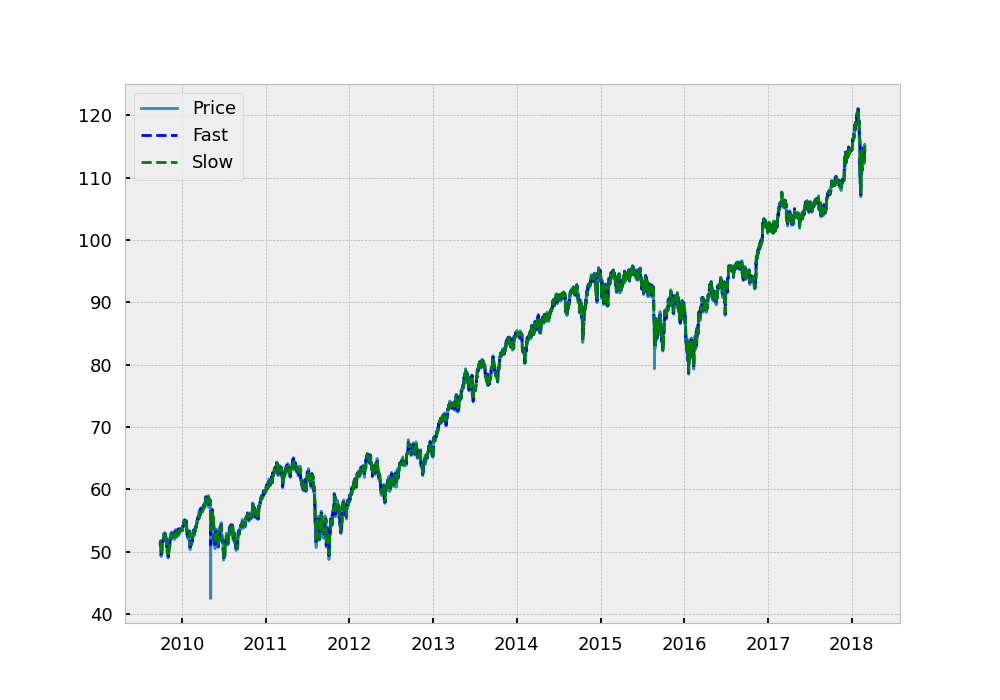

In [29]:
%matplotlib widget
f,ax=plt.subplots()
ax.plot(close_df.price, label='Price')
ax.plot(close_df.fast, 'b--', label='Fast')
ax.plot(close_df.slow, 'g--', label='Slow')
ax.legend()
ax.grid(True)

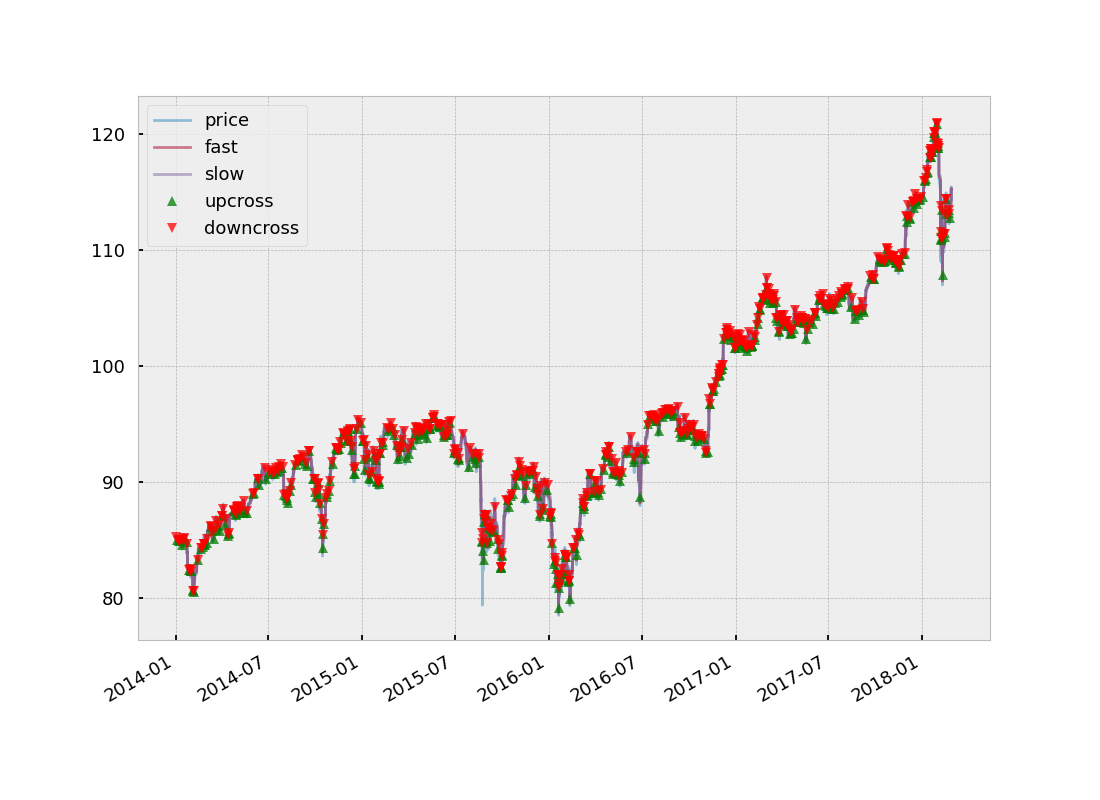

In [30]:
def get_up_cross(df):
    crit1 = df.fast.shift(1) < df.slow.shift(1)
    crit2 = df.fast > df.slow
    return df.fast[(crit1) & (crit2)]

def get_down_cross(df):
    crit1 = df.fast.shift(1) > df.slow.shift(1)
    crit2 = df.fast < df.slow
    return df.fast[(crit1) & (crit2)]

up = get_up_cross(close_df)
down = get_down_cross(close_df)

f, ax = plt.subplots(figsize=(11,8))

close_df.loc['2014':].plot(ax=ax, alpha=.5)
up.loc['2014':].plot(ax=ax,ls='',marker='^', markersize=7,
                     alpha=0.75, label='upcross', color='g')
down.loc['2014':].plot(ax=ax,ls='',marker='v', markersize=7, 
                       alpha=0.75, label='downcross', color='r')

ax.legend()

#### (a) Derive meta-labels for ptSl = [1,2] and t1 where numdays=1. Use as trgt dailyVol computed by snippet 3.1 (get events with sides)

In [31]:
side_up = pd.Series(1, index=up.index)
side_down = pd.Series(-1, index=down.index)
side = pd.concat([side_up,side_down]).sort_index()
print(side)

2009-09-30 09:45:21   -1
2009-10-05 10:41:50    1
2009-10-16 10:40:43   -1
2009-10-19 10:46:14    1
2009-10-20 11:50:28   -1
                      ..
2018-02-21 11:10:00    1
2018-02-21 15:12:30   -1
2018-02-22 11:48:39    1
2018-02-22 13:34:29   -1
2018-02-23 10:01:41    1
Length: 1712, dtype: int64


In [32]:
minRet = .01 
ptsl = [1,2]

dailyVol = fns.getDailyVol(close_df['price'])
tEvents = fns.getTEvents(close_df['price'], h=dailyVol.mean())
tEvents = tEvents[1:]
t1 = fns.addVerticalBarrier(tEvents, close_df['price'], numDays=1)
up = get_up_cross(close_df)
down = get_down_cross(close_df)
side_up = pd.Series(1, index=up.index)
side_down = pd.Series(-1, index=down.index)
side = pd.concat([side_up,side_down]).sort_index()
ma_events = fns.getEvents(close = close_df['price'],
                      tEvents = tEvents,
                      ptSl = ptsl,
                      trgt = target,
                      minRet = minRet,
                      numThreads = 8,
                      t1 = t1,
                      side = side)
print(ma_events)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30858/30858 [00:00<00:00, 50674.60it/s]


                                     t1      trgt  side
2009-10-05 14:55:48 2009-10-06 15:35:49  0.013612   NaN
2009-10-06 09:29:52 2009-10-07 09:47:16  0.015728   NaN
2009-10-06 11:32:02 2009-10-07 11:48:22  0.016744   NaN
2009-10-06 14:07:37 2009-10-07 14:22:36  0.016971   NaN
2009-10-08 09:29:51 2009-10-09 09:31:12  0.014877   NaN
...                                 ...       ...   ...
2018-02-13 13:43:37 2018-02-14 13:53:59  0.014365   NaN
2018-02-14 10:30:48 2018-02-15 10:42:27  0.012136   NaN
2018-02-14 13:36:02 2018-02-15 13:42:09  0.011688   NaN
2018-02-15 09:31:56 2018-02-16 09:42:36  0.011244   NaN
2018-02-15 14:05:41 2018-02-16 14:15:08  0.010183   NaN

[929 rows x 3 columns]


2024-03-24 15:23:54.639165 100.0% applyPtSlOnT1 done after 0.0 minutes. Remaining 0.0 minutes.


In [33]:
ma_events.head(1000)

,t1,trgt,side
2009-10-05 14:55:48,2009-10-06 15:35:49,0.013612,NaN
2009-10-06 09:29:52,2009-10-07 09:47:16,0.015728,NaN
2009-10-06 11:32:02,2009-10-07 11:48:22,0.016744,NaN
2009-10-06 14:07:37,2009-10-07 14:22:36,0.016971,NaN
2009-10-08 09:29:51,2009-10-09 09:31:12,0.014877,NaN
...,...,...,...
2018-02-13 13:43:37,2018-02-14 13:53:59,0.014365,NaN
2018-02-14 10:30:48,2018-02-15 10:42:27,0.012136,NaN
2018-02-14 13:36:02,2018-02-15 13:42:09,0.011688,NaN
2018-02-15 09:31:56,2018-02-16 09:42:36,0.011244,NaN


In [34]:
ma_events.side.value_counts()

side
 1.0    53
-1.0    49
Name: count, dtype: int64

In [35]:
ma_side = ma_events.dropna().side

In [36]:
ma_bins = fns.getBinsNew(ma_events,close_df['price'], t1).dropna()
print(ma_bins)

                          ret  bin
2009-10-29 13:40:22 -0.021789  0.0
2009-10-30 11:51:20  0.016593  1.0
2009-11-02 12:23:50  0.006018  1.0
2009-11-16 10:11:56 -0.005795  0.0
2009-11-23 10:00:28 -0.010502  0.0
...                       ...  ...
2016-07-07 14:28:00 -0.018703  0.0
2016-07-08 09:30:57  0.010571  1.0
2018-02-06 10:18:08 -0.026702  0.0
2018-02-07 15:28:09 -0.030792  0.0
2018-02-13 09:30:00 -0.001803  0.0

[102 rows x 2 columns]


In [37]:
Xx = pd.merge_asof(ma_bins, side.to_frame().rename(columns={0:'side'}),
                   left_index=True, right_index=True, direction='forward')
print(Xx)

                          ret  bin  side
2009-10-29 13:40:22 -0.021789  0.0   NaN
2009-10-30 11:51:20  0.016593  1.0   NaN
2009-11-02 12:23:50  0.006018  1.0   NaN
2009-11-16 10:11:56 -0.005795  0.0   NaN
2009-11-23 10:00:28 -0.010502  0.0   NaN
...                       ...  ...   ...
2016-07-07 14:28:00 -0.018703  0.0   NaN
2016-07-08 09:30:57  0.010571  1.0   NaN
2018-02-06 10:18:08 -0.026702  0.0   NaN
2018-02-07 15:28:09 -0.030792  0.0   NaN
2018-02-13 09:30:00 -0.001803  0.0   NaN

[102 rows x 3 columns]


#### (b) Train Random Forest to decide whether to trade or not {0,1} since underlying model (crossing m.a.) has decided the side, {-1,1}

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        24
         1.0       0.53      1.00      0.69        27

    accuracy                           0.53        51
   macro avg       0.26      0.50      0.35        51
weighted avg       0.28      0.53      0.37        51



/media/singularity/data/projects/machine-learning/Advances-in-Financial-Machine-Learning/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/singularity/data/projects/machine-learning/Advances-in-Financial-Machine-Learning/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/singularity/data/projects/machine-learning/Advances-in-Financial-Machine-Learning/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are

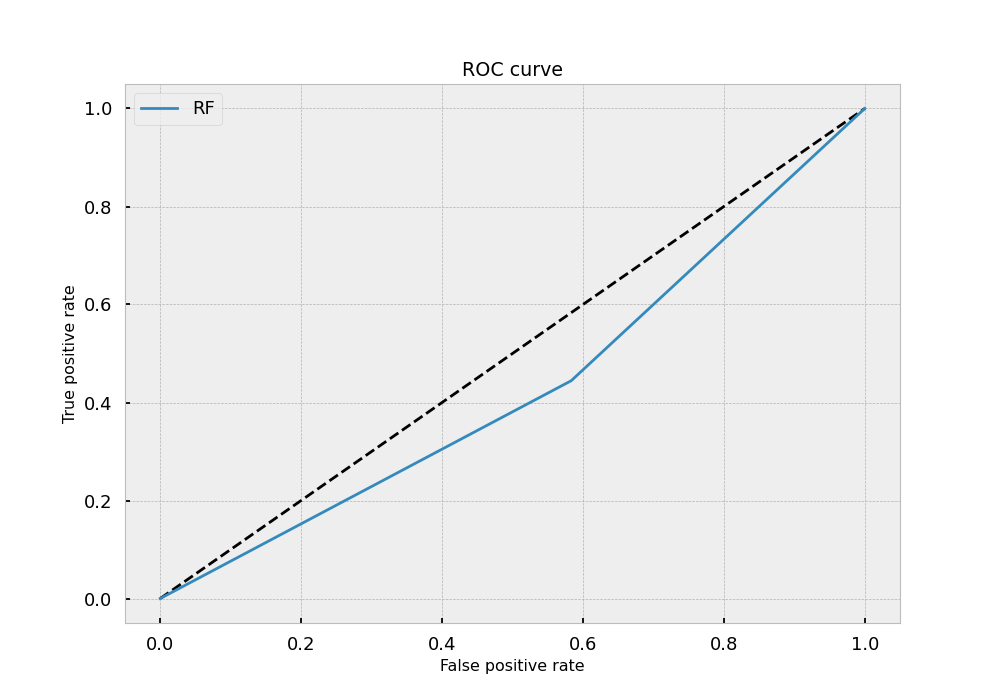

In [38]:
X = ma_side.values.reshape(-1,1)
y = ma_bins.bin.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)

n_estimator = 10000
rf = RandomForestClassifier(max_depth=2, n_estimators=n_estimator,
                            criterion='entropy', random_state=RANDOM_STATE)
rf.fit(X_train, y_train)

# The random forest model by itself
y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred))

f,ax=plt.subplots()
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr_rf, tpr_rf, label='RF')
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.set_title('ROC curve')
ax.legend(loc='best')
ax.grid(True)

### [3.5] Develop mean-reverting Bollinger Band Strategy. For each obs. model suggests a side but not size of the bet.

In [39]:
def bbands(price, window=None, width=None, numsd=None):
    """ returns average, upper band, and lower band"""
    ave = price.rolling(window).mean()
    sd = price.rolling(window).std(ddof=0)
    if width:
        upband = ave * (1+width)
        dnband = ave * (1-width)
        return price, np.round(ave,3), np.round(upband,3), np.round(dnband,3)        
    if numsd:
        upband = ave + (sd*numsd)
        dnband = ave - (sd*numsd)
        return price, np.round(ave,3), np.round(upband,3), np.round(dnband,3)

In [40]:
window=50
bb_df = pd.DataFrame()
bb_df['price'],bb_df['ave'],bb_df['upper'],bb_df['lower']=bbands(close, window=window, numsd=1)
bb_df.dropna(inplace=True)
print(bb_df)

                          price      ave    upper    lower
2009-10-01 15:51:02   49.996667   51.079   51.603   50.554
2009-10-01 16:16:36   50.316600   51.062   51.597   50.527
2009-10-02 09:44:14   49.240000   51.023   51.615   50.431
2009-10-02 10:02:18   49.390000   50.987   51.621   50.353
2009-10-02 10:18:42   49.420000   50.948   51.616   50.279
...                         ...      ...      ...      ...
2018-02-26 15:31:06  115.290000  114.005  114.959  113.051
2018-02-26 15:40:15  115.410000  114.069  115.008  113.129
2018-02-26 15:49:42  115.200000  114.124  115.047  113.202
2018-02-26 15:59:04  115.270000  114.183  115.083  113.282
2018-02-26 16:16:14  115.300000  114.231  115.125  113.338

[30811 rows x 4 columns]


<Axes: >

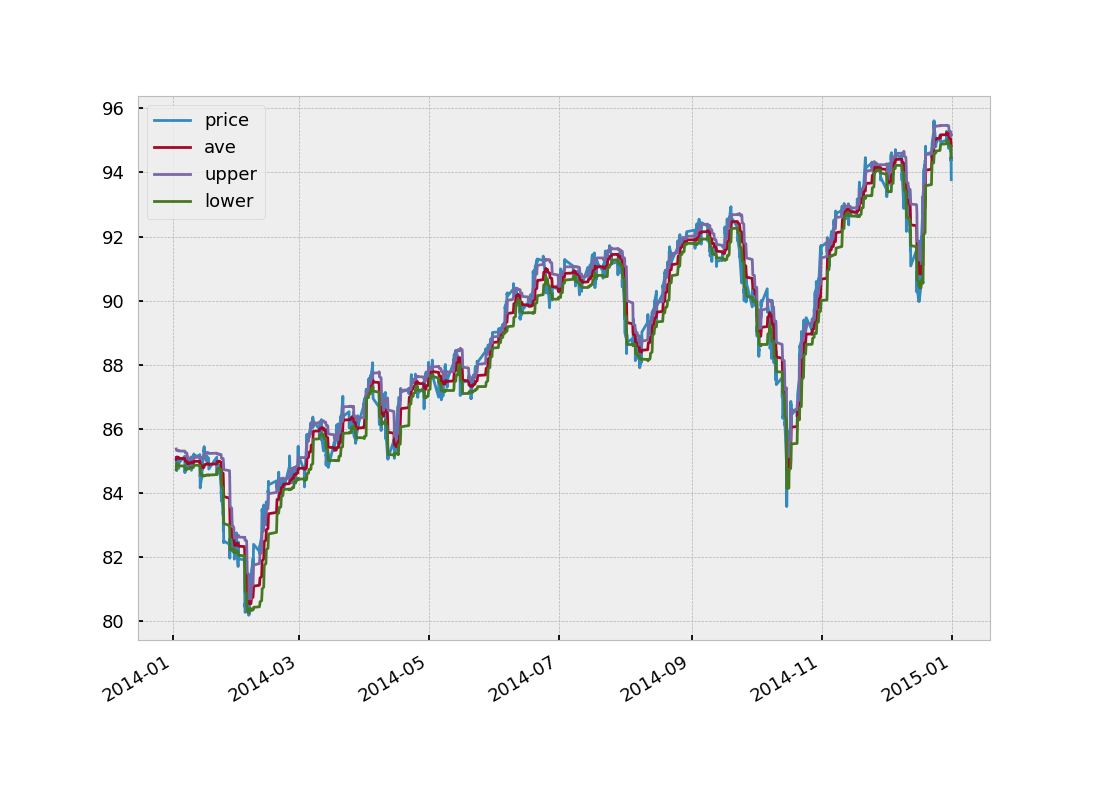

In [41]:
f,ax=plt.subplots(figsize=(11,8))
bb_df.loc['2014'].plot(ax=ax)

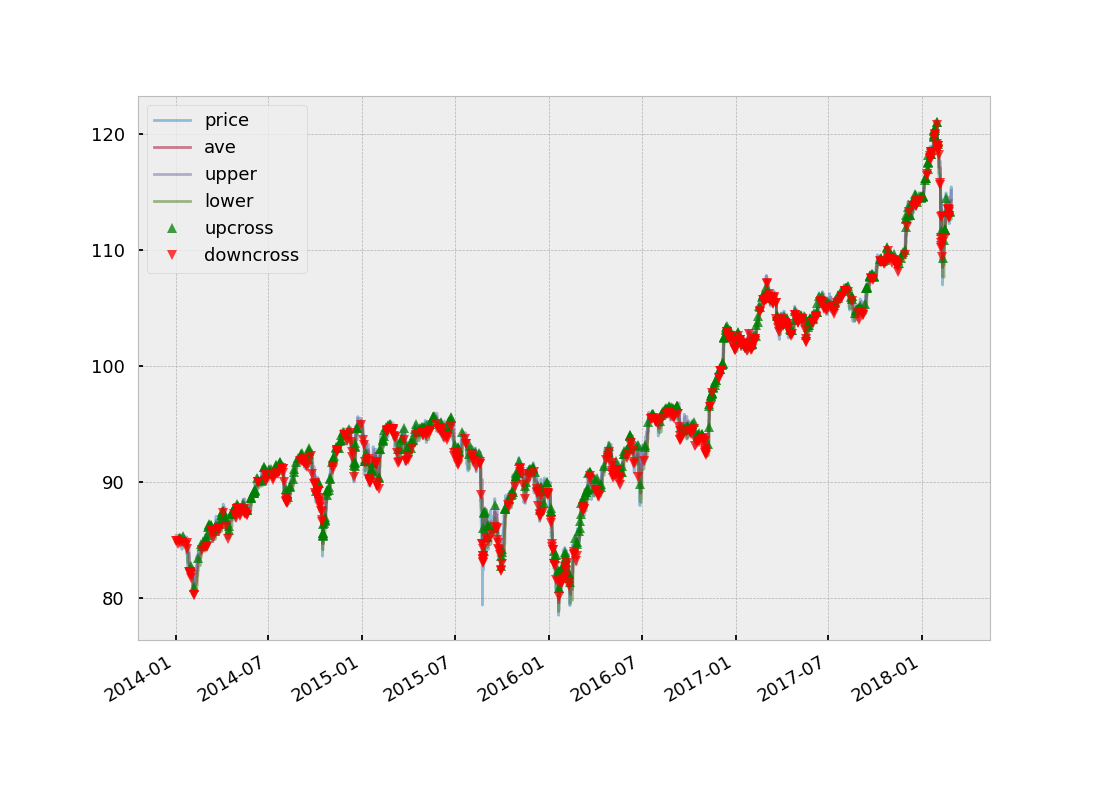

In [42]:
def get_up_cross(df, col):
    # col is price column
    crit1 = df[col].shift(1) < df.upper.shift(1)  
    crit2 = df[col] > df.upper
    return df[col][(crit1) & (crit2)]

def get_down_cross(df, col):
    # col is price column    
    crit1 = df[col].shift(1) > df.lower.shift(1) 
    crit2 = df[col] < df.lower
    return df[col][(crit1) & (crit2)]

bb_down = get_down_cross(bb_df, 'price')
bb_up = get_up_cross(bb_df, 'price') 

f, ax = plt.subplots(figsize=(11,8))

bb_df.loc['2014':].plot(ax=ax, alpha=.5)
bb_up.loc['2014':].plot(ax=ax, ls='', marker='^', markersize=7,
                        alpha=0.75, label='upcross', color='g')
bb_down.loc['2014':].plot(ax=ax, ls='', marker='v', markersize=7, 
                          alpha=0.75, label='downcross', color='r')
ax.legend()


#### (a) Derive meta-labels for ptSl=[0,2] and t1 where numdays=1. Use as trgt dailyVol.

In [43]:
bb_side_up = pd.Series(-1, index=bb_up.index) # sell on up cross for mean reversion
bb_side_down = pd.Series(1, index=bb_down.index) # buy on down cross for mean reversion
bb_side_raw = pd.concat([bb_side_up,bb_side_down]).sort_index()
print(bb_side_raw)

minRet = .01 
ptsl=[0,2]
bb_events = fns.getEvents(close,tEvents,ptsl,target,minRet,cpus,t1=t1,side=bb_side_raw)
print(bb_events)

bb_side = bb_events.dropna().side
print(bb_side)

2009-10-06 09:29:52   -1
2009-10-06 14:52:03   -1
2009-10-13 12:08:01   -1
2009-10-14 09:29:52   -1
2009-10-19 10:46:14   -1
                      ..
2018-02-22 13:34:29    1
2018-02-22 14:20:25    1
2018-02-22 14:44:33    1
2018-02-23 13:41:26   -1
2018-02-23 14:40:49   -1
Length: 2040, dtype: int64
                                     t1      trgt  side
2009-10-05 14:55:48 2009-10-06 15:35:49  0.013612   NaN
2009-10-06 09:29:52 2009-10-07 09:47:16  0.015728  -1.0
2009-10-06 11:32:02 2009-10-07 11:48:22  0.016744   NaN
2009-10-06 14:07:37 2009-10-07 14:22:36  0.016971   NaN
2009-10-08 09:29:51 2009-10-09 09:31:12  0.014877   NaN
...                                 ...       ...   ...
2018-02-13 13:43:37 2018-02-14 13:53:59  0.014365  -1.0
2018-02-14 10:30:48 2018-02-15 10:42:27  0.012136   NaN
2018-02-14 13:36:02 2018-02-15 13:42:09  0.011688   NaN
2018-02-15 09:31:56 2018-02-16 09:42:36  0.011244   NaN
2018-02-15 14:05:41 2018-02-16 14:15:08  0.010183   NaN

[929 rows x 3 columns]
20

2024-03-24 15:24:05.940886 100.0% applyPtSlOnT1 done after 0.0 minutes. Remaining 0.0 minutes..


In [44]:
bb_side.value_counts()

side
 1.0    72
-1.0    67
Name: count, dtype: int64

In [45]:
bb_bins = fns.getBins(bb_events,close).dropna()
print(bb_bins)
print(bb_bins.bin.value_counts())

                          ret  bin
2009-10-06 09:29:52 -0.000982  0.0
2009-10-14 09:29:52 -0.001899  0.0
2009-10-23 10:57:52  0.002465  1.0
2009-10-26 11:32:02 -0.009459  0.0
2009-10-30 11:51:20 -0.009356  0.0
...                       ...  ...
2016-07-07 10:17:10 -0.003791  0.0
2016-07-08 09:30:57 -0.010571  0.0
2018-02-06 10:18:08  0.025085  1.0
2018-02-06 14:19:57  0.028779  1.0
2018-02-13 13:43:37 -0.010108  0.0

[139 rows x 2 columns]
bin
0.0    79
1.0    60
Name: count, dtype: int64


#### (b) train random forest to decide to trade or not. Use features: volatility, serial correlation, and the crossing moving averages from exercise 2.

In [46]:
def returns(s):
    arr = np.diff(np.log(s))
    return (pd.Series(arr, index=s.index[1:]))

def df_rolling_autocorr(df, window, lag=1):
    """Compute rolling column-wise autocorrelation for a DataFrame."""

    return (df.rolling(window=window)
            .corr(df.shift(lag))) # could .dropna() here

#df_rolling_autocorr(d1, window=21).dropna().head()



In [47]:
srl_corr = df_rolling_autocorr(returns(close), window=window).rename('srl_corr')
print(srl_corr)

2009-09-28 10:06:04         NaN
2009-09-28 10:19:50         NaN
2009-09-28 10:32:01         NaN
2009-09-28 10:53:46         NaN
2009-09-28 11:22:01         NaN
                         ...   
2018-02-26 15:31:06    0.028037
2018-02-26 15:40:15    0.015957
2018-02-26 15:49:42    0.032877
2018-02-26 15:59:04    0.046014
2018-02-26 16:16:14    0.109129
Name: srl_corr, Length: 30859, dtype: float64


In [48]:
features = (pd.DataFrame()
            .assign(vol=bb_events.trgt)
            .assign(ma_side=ma_side)
            .assign(srl_corr=srl_corr)
            .drop_duplicates()
            .dropna())
print(features)

                          vol  ma_side  srl_corr
2009-10-29 13:40:22  0.010405      1.0 -0.007606
2009-10-30 11:51:20  0.011860     -1.0  0.025061
2009-11-02 12:23:50  0.014008     -1.0 -0.001253
2009-11-16 10:11:56  0.010142      1.0 -0.005013
2009-11-23 10:00:28  0.010491      1.0  0.036506
...                       ...      ...       ...
2016-07-07 14:28:00  0.012624     -1.0  0.251865
2016-07-08 09:30:57  0.011944      1.0  0.238590
2018-02-06 10:18:08  0.013317     -1.0  0.123961
2018-02-07 15:28:09  0.024870      1.0 -0.005597
2018-02-13 09:30:00  0.017363     -1.0  0.198935

[102 rows x 3 columns]


In [49]:
Xy = (pd.merge_asof(features, bb_bins[['bin']], 
                    left_index=True, right_index=True, 
                    direction='forward').dropna())
print(Xy)

                          vol  ma_side  srl_corr  bin
2009-10-29 13:40:22  0.010405      1.0 -0.007606  0.0
2009-10-30 11:51:20  0.011860     -1.0  0.025061  0.0
2009-11-02 12:23:50  0.014008     -1.0 -0.001253  0.0
2009-11-16 10:11:56  0.010142      1.0 -0.005013  1.0
2009-11-23 10:00:28  0.010491      1.0  0.036506  1.0
...                       ...      ...       ...  ...
2016-07-07 14:28:00  0.012624     -1.0  0.251865  0.0
2016-07-08 09:30:57  0.011944      1.0  0.238590  0.0
2018-02-06 10:18:08  0.013317     -1.0  0.123961  1.0
2018-02-07 15:28:09  0.024870      1.0 -0.005597  0.0
2018-02-13 09:30:00  0.017363     -1.0  0.198935  0.0

[102 rows x 4 columns]


In [50]:
Xy.bin.value_counts()

bin
0.0    60
1.0    42
Name: count, dtype: int64

              precision    recall  f1-score   support

    no_trade       0.47      0.73      0.58        26
       trade       0.36      0.16      0.22        25

    accuracy                           0.45        51
   macro avg       0.42      0.45      0.40        51
weighted avg       0.42      0.45      0.40        51



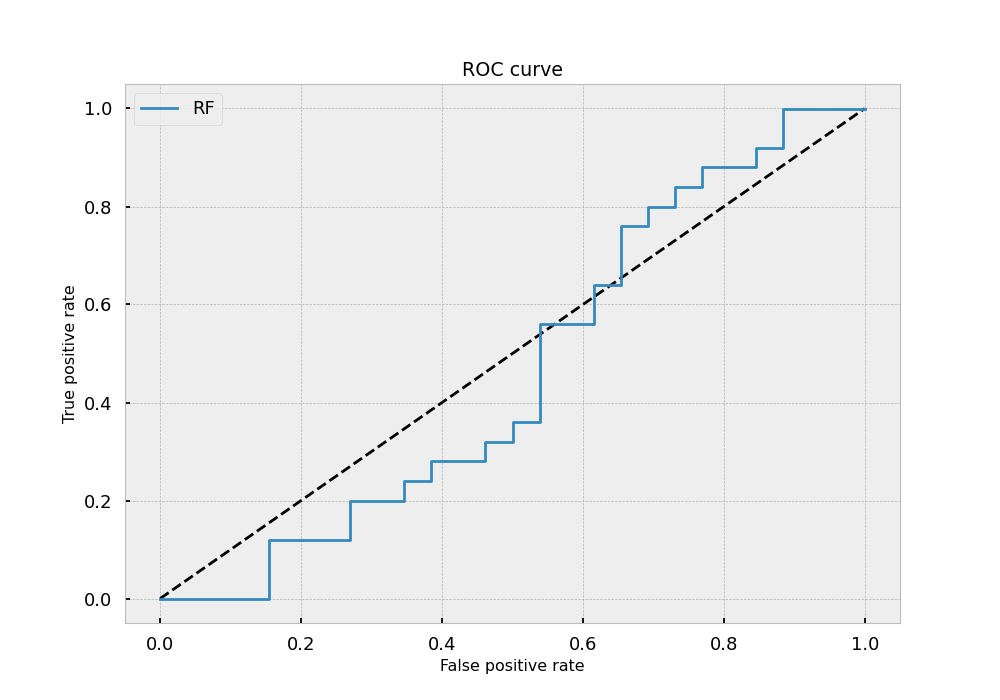

In [51]:
X = Xy.drop('bin',axis=1).values
y = Xy['bin'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,
                                                    shuffle=False)

n_estimator = 10000
rf = RandomForestClassifier(max_depth=2, n_estimators=n_estimator,
                            criterion='entropy', random_state=RANDOM_STATE)
rf.fit(X_train, y_train)

# The random forest model by itself
y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred, target_names=['no_trade','trade']))

f,ax=plt.subplots()
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr_rf, tpr_rf, label='RF')
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.set_title('ROC curve')
ax.legend(loc='best')
ax.grid(True)

#### (c) What is accuracy of predictions from primary model if the secondary model does not filter bets? What is classification report?

2024-03-24 15:24:16.178699 100.0% applyPtSlOnT1 done after 0.0 minutes. Remaining 0.0 minutes..


                                     t1      trgt
2009-10-05 14:55:48 2009-10-06 15:35:49  0.013612
2009-10-06 09:29:52 2009-10-07 09:47:16  0.015728
2009-10-06 11:32:02 2009-10-07 11:48:22  0.016744
2009-10-06 14:07:37 2009-10-07 14:22:36  0.016971
2009-10-08 09:29:51 2009-10-09 09:31:12  0.014877
...                                 ...       ...
2018-02-13 13:43:37 2018-02-14 13:53:59  0.014365
2018-02-14 10:30:48 2018-02-15 10:42:27  0.012136
2018-02-14 13:36:02 2018-02-15 13:42:09  0.011688
2018-02-15 09:31:56 2018-02-16 09:42:36  0.011244
2018-02-15 14:05:41 2018-02-16 14:15:08  0.010183

[929 rows x 2 columns]
                          ret  bin
2009-10-05 14:55:48  0.012408  1.0
2009-10-06 09:29:52  0.000982  1.0
2009-10-06 11:32:02 -0.006544 -1.0
2009-10-06 14:07:37  0.002648  1.0
2009-10-08 09:29:51 -0.003092 -1.0
...                       ...  ...
2018-02-13 13:43:37  0.010108  1.0
2018-02-14 10:30:48  0.010876  1.0
2018-02-14 13:36:02  0.005056  1.0
2018-02-15 09:31:56  0.003

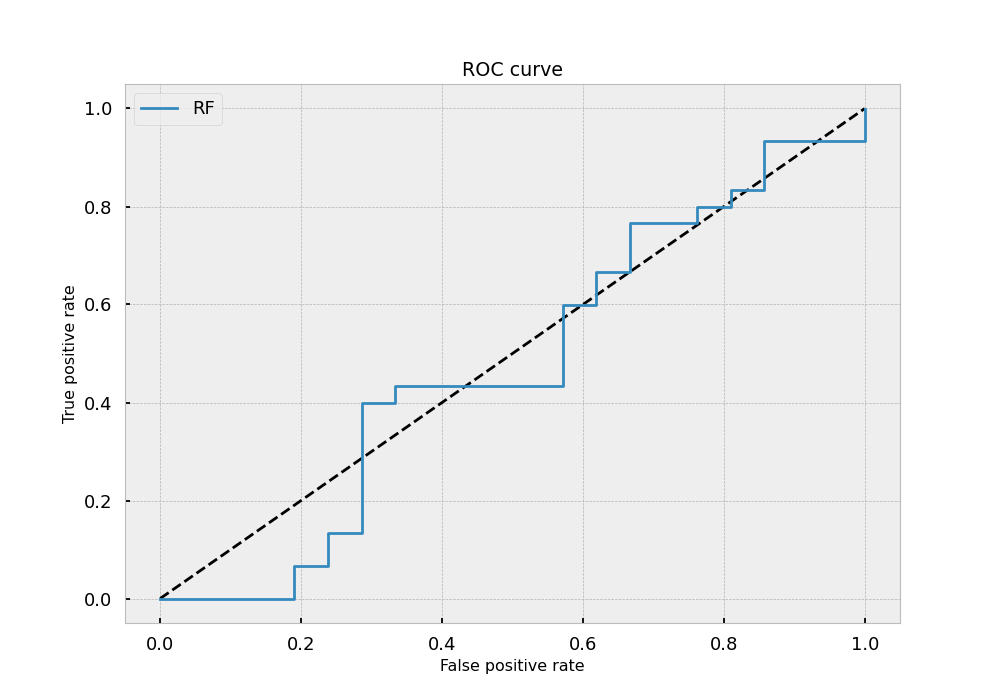

In [52]:
minRet = .01 
ptsl=[0,2]
bb_events = fns.getEvents(close,tEvents,ptsl,target,minRet,cpus,t1=t1)
print(bb_events)

bb_bins = fns.getBins(bb_events,close).dropna()
print(bb_bins)

features = (pd.DataFrame()
            .assign(vol=bb_events.trgt)
            .assign(ma_side=ma_side)
            .assign(srl_corr=srl_corr)
            .drop_duplicates()
            .dropna())
print(features)

Xy = (pd.merge_asof(features, bb_bins[['bin']], 
                    left_index=True, right_index=True, 
                    direction='forward').dropna())
print(Xy)

### run model ###
X = Xy.drop('bin',axis=1).values
y = Xy['bin'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,
                                                    shuffle=False)

n_estimator = 10000
rf = RandomForestClassifier(max_depth=2, n_estimators=n_estimator,
                            criterion='entropy', random_state=RANDOM_STATE)
rf.fit(X_train, y_train)

# The random forest model by itself
y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred, 
                            target_names=['no_trade','trade']))

f,ax=plt.subplots()
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr_rf, tpr_rf, label='RF')
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.set_title('ROC curve')
ax.legend(loc='best')
ax.grid(True)